In [1]:
# logging 
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [2]:
# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_maze

maze = gym.make('Maze4-v0')
print("This is how maze looks like")
situation = maze.reset()
print(type(situation))
print(situation)
maze.render()

This is how maze looks like
<class 'tuple'>
('1', '0', '0', '1', '1', '1', '0', '0')

■ ■ ■ ■ ■ ■ ■ ■
■ □ □ ■ □ □ $ ■
■ ■ □ □ ■ □ □ ■
■ ■ □ ■ □ □ ■ ■
■ □ □ □ □ □ □ ■
■ ■ □ ■ □ □ □ ■
■ □ □ A □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■


In [3]:
from lcs.agents.xcs import XCS, Configuration


def xcs_maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_all_possible_transitions()
    nr_correct = 0
    for start, action, end in transitions:
        perception = environment.env.maze.perception(*start)
        if any([True for cl in population
                if cl.does_match(perception) and
                cl.action == action and
                cl.fitness > 0.05 and cl.experience > 10
               ]):
            nr_correct += 1
    return nr_correct / len(transitions)

def xcs_maze_metrics(xcs: XCS, environment):
    return {
        'numerosity': xcs.population.numerosity,
        'knowledge': xcs_maze_knowledge(xcs.population, environment),
        'population': len(xcs.population)
    }


cfg = Configuration(number_of_actions=8,
                    max_population=500,
                    metrics_trial_frequency=50,
                    covering_wildcard_chance = 0.9,
                    user_metrics_collector_fcn=xcs_maze_metrics)

agent = XCS(cfg)
explore_population, explore_metrics = agent.explore(maze, 1000, False)

for cl in explore_population:
    print(str(cl))




INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': [1.5301726295369803e-40, 2.9628335112475754e-41, 1.0763429932947299e-40, 1.029860890432868e-40, 1.079122841763972e-40, 3.0171094084287077e-40, 3.0892718727863758e-40, 1.347255625904577e-40], 'numerosity': 149, 'knowledge': 0.0, 'population': 116}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 50, 'reward': [65.13545757543363, 71.7968371817136, 19.975789809818416, 20.84760360076376, 12.544369354212456, 16.487622891392935, 17.914488512210948, 21.154314319929618], 'numerosity': 500, 'knowledge': 0.09565217391304348, 'population': 371}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 4, 'reward': [19.467034469756253, 238.6445597037926, 18.807703840998723, 25.25220498836992, 20.690167417418607, 18.61803648320854, 17.320797586457743, 18.716493169862225], 'numerosity': 500, 'knowledge': 0.12173913043478261, 'population': 364}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 50, 'reward': [27.70326127172787,

Cond:01010110 - Act:5 - Num:1 [fit: 0.000066, exp: 71.00, pred: 181.119, error:12.879608856950828]
Cond:1#011100 - Act:5 - Num:1 [fit: 0.003231, exp: 27.00, pred: 180.979, error:20.324376180734752]
Cond:10011100 - Act:3 - Num:1 [fit: 0.003225, exp: 33.00, pred: 173.329, error:36.14543904412188]
Cond:#0001000 - Act:7 - Num:1 [fit: 0.183250, exp: 191.00, pred: 192.058, error:9.907697262508693]
Cond:10101000 - Act:5 - Num:3 [fit: 0.480925, exp: 124.00, pred: 198.542, error:6.044951855408749]
Cond:11#00101 - Act:6 - Num:1 [fit: 0.002936, exp: 560.00, pred: 185.916, error:16.797102752636935]
Cond:11001011 - Act:2 - Num:1 [fit: 0.000001, exp: 465.00, pred: 191.393, error:27.747312185104626]
Cond:09010010 - Act:3 - Num:2 [fit: 0.000127, exp: 93.00, pred: 183.391, error:16.71977206615307]
Cond:00000101 - Act:3 - Num:2 [fit: 0.029010, exp: 71.00, pred: 169.134, error:21.41935006764928]
Cond:00#00001 - Act:0 - Num:1 [fit: 0.000000, exp: 269.00, pred: 184.799, error:15.438576178489333]
Cond:00100

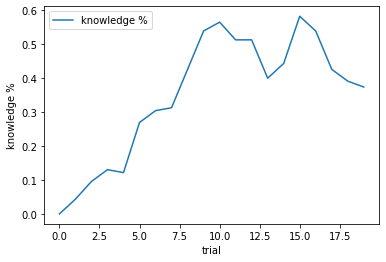

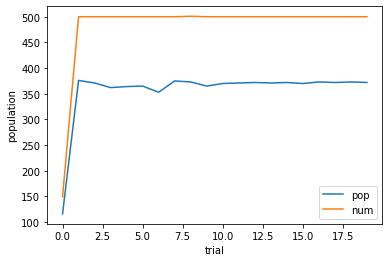

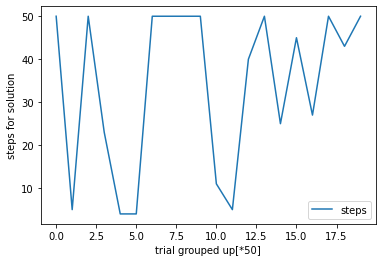

In [4]:
import pandas as pd
import numpy as np

df = pd.DataFrame(metric["knowledge"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("knowledge %")
ax.legend(["knowledge %"])


df = pd.DataFrame(zip([metric["population"] for metric in explore_metrics], [metric["numerosity"] for metric in explore_metrics]))
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["pop", "num"])

steps_averaged = []



xf = [metric["steps_in_trial"] for metric in explore_metrics]
temp_df = np.array_split(xf, 20)
for i in range(len(temp_df)):
    temp_df[i] = np.mean(temp_df[i]) 
df = pd.DataFrame(temp_df)
# df = pd.DataFrame(metric["steps_in_trial"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial grouped up[*50]")
ax.set_ylabel("steps for solution")
ax.legend(["steps"])


In [5]:
# It is hard to say but
# looking at amount of times algorithm reaches top steps (50) the steps might actually go down over trials.
# I need to somehow smooth it to see it better
